In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import CoraFull, BitcoinOTC
from torch_geometric.utils import is_undirected
import matplotlib.pyplot as plt
from torch_geometric.nn import SAGEConv
import pandas as pd
import os
import numpy as np
from datetime import datetime

#### Create Dataset

In [6]:
dataset = CoraFull("./datasets")

In [7]:
dataset.data.edge_index = dataset.data.edge_index[:,:10000]

### Trash

In [ ]:
sorted_ratings = pd.read_csv("../datasets/movielens/sorted_ratings.csv", header=None)

In [85]:
num_nodes = np.unique(np.hstack((sorted_ratings[0].unique(), sorted_ratings[1].unique()))).size
x = np.random.normal(size=(num_nodes, 7))
edge_index = torch.tensor(np.vstack((sorted_ratings[0].values, sorted_ratings[1].values)))

data = Data(x=x, edge_index=edge_index)


In [108]:
data.num_node_features = 7

### Model Definitions

In [8]:
class GraphSage(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_node_features, 128)
        self.conv2 = SAGEConv(128, 64)
        self.ff = torch.nn.Sequential(
            torch.nn.Linear(64,64),
            torch.nn.Linear(64, dataset.num_classes)
        )
    
    def fortward_no_output(self,data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return x
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        if self.training:
            x = F.dropout(x, 0.2)
        return self.ff(x)
        # return F.softmax(x)
model = GraphSage()


### Training Loop for 2 layered GCN Normal

In [49]:
losses = list()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(dataset[0])
    loss = F.cross_entropy(out, dataset[0].y)
    loss.backward()
    losses.append(loss)
    optimizer.step()
    


KeyboardInterrupt: 

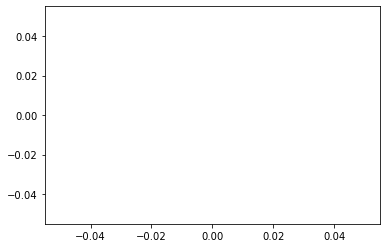

In [30]:
plt.plot(range(0, len(losses) ),losses)

### Saving model weights for Java

In [9]:
def save_model(model_name):
    directory = os.path.join(os.path.curdir, "models/%s-%s/"%(model_name, datetime.now().date()))
    if not os.path.exists(directory):
        os.makedirs(directory)
    i = 0
    for name, param in model.named_parameters():
        np.save(os.path.join(directory, str(i)), param.data.numpy())
        i+=1

In [10]:
def load_model(model_folder):
    directory = os.path.join(os.path.curdir, "models/%s"%(model_folder))
    onlyfiles = [f for f in os.listdir(directory)]
    onlyfiles.sort()
    for i, param in enumerate(model.parameters()):
        tmp = np.load(os.path.join(directory, onlyfiles[i]))
        param.data = torch.tensor(tmp)

### Saving Graph for Java

In [4]:
edges = pd.DataFrame(dataset.data.edge_index.numpy().T)
edges.to_csv("datasets/cora/edges", index = False, header=False)

In [4]:
np.save("datasets/cora/vertex_features", dataset.data.x.numpy())

In [5]:
np.save("datasets/cora/vertex_labels", dataset.data.y.numpy())

## Testing the saved model

In [11]:
load_model("GraphSageBias-2022-05-15")

In [12]:
model.training = False

In [13]:
out = model.fortward_no_output(dataset.data)

In [14]:
out[193]

tensor([0.0000, 0.0671, 0.0000, 0.3636, 0.1301, 1.4143, 0.6575, 0.4067, 1.2493,
        0.0000, 1.4117, 0.7736, 0.8188, 0.0000, 1.0199, 1.0499, 0.0000, 0.0000,
        0.0000, 1.4162, 0.8516, 1.4925, 0.4122, 0.0581, 0.7633, 0.0000, 0.2815,
        0.6440, 0.1724, 0.3091, 0.0000, 0.6307, 0.8696, 0.8137, 0.7733, 0.7752,
        0.0000, 0.0294, 0.7573, 0.9862, 0.6851, 0.6395, 1.4788, 0.0000, 1.1253,
        0.7743, 0.9550, 0.0000, 1.4315, 0.2231, 0.0000, 0.0429, 0.1695, 0.0000,
        1.3839, 0.0000, 1.4677, 0.6671, 0.5835, 0.8522, 0.7849, 0.6056, 0.0000,
        0.2725], grad_fn=<SelectBackward0>)

In [52]:
for i,j in model.named_parameters():
    print(i,j.shape,j)

conv1.lin_l.weight torch.Size([128, 8710]) Parameter containing:
tensor([[-1.1213e-02,  2.1251e-03,  3.5721e-03,  ..., -1.9507e-03,
          1.6900e-02,  5.1516e-03],
        [ 2.8658e-04,  2.2471e-05,  7.6836e-05,  ..., -2.6370e-05,
         -3.2836e-04,  6.3618e-05],
        [ 4.4200e-04, -4.4746e-06,  9.8639e-04,  ...,  1.4028e-05,
         -1.7615e-04, -2.4735e-05],
        ...,
        [-2.7859e-04,  2.1294e-04,  4.1929e-03,  ...,  1.7834e-05,
         -1.3354e-04, -2.9501e-04],
        [ 2.9670e-04,  5.9558e-03, -1.9688e-03,  ..., -1.4719e-04,
         -8.6875e-03, -2.2669e-03],
        [-2.2037e-04,  2.1224e-05, -3.5138e-05,  ..., -2.5063e-06,
         -7.4994e-06, -2.1843e-05]], requires_grad=True)
conv1.lin_l.bias torch.Size([128]) Parameter containing:
tensor([ 2.2002e-01,  2.5693e-02, -5.4645e-03, -3.1824e-04, -2.6723e-02,
         1.3266e-01,  6.8037e-02,  4.9409e-02, -3.5273e-02,  1.4855e-02,
         8.2995e-02,  1.0349e-01,  1.7266e-02, -6.1273e-02, -3.9598e-04,
       

In [44]:
accuracies = pd.read_csv("/Users/rustamwarwick/Desktop/output_full.txt", header=None)[0].values

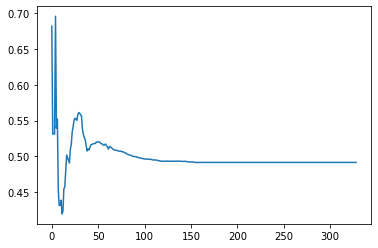

In [46]:
plt.plot( range(len(accuracies)), accuracies)